In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime as dt
import lightgbm as lgb
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.model_selection import GridSearchCV
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import SelectKBest

In [2]:
def date_formatter(date):
    """creates datetime type for object"""
    return dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

# df dataframe cleaning and feature engineering

In [3]:
df = pd.read_csv('takehome_user_engagement.csv', parse_dates = [0], date_parser = date_formatter) 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
# visited columns are all ones, to be deleted
df.visited.unique()

array([1], dtype=int64)

In [6]:
# change type to category to satisfy format
df.user_id = df.user_id.astype('category')

In [7]:
def seven_day_window(df, freq):
    """creates a window of seven days and counts the number of logins within that window"""
    return df.rolling(freq, on='time_stamp').user_id.count()

df['seven_day'] = df.groupby('user_id', as_index = False, group_keys = False).apply(seven_day_window, '7D')
df.head()

,time_stamp,user_id,visited,seven_day
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [8]:
# determine if users can be considered adopted or not based on three logins within one week policy 
df['adopted'] = 0
df.loc[df['seven_day'] >= 3, 'adopted'] = 1
        

In [9]:
# count number of logins for each user
number_logins = df.user_id.value_counts().sort_index().to_frame('number_logins')
df = df.merge(number_logins, left_on = 'user_id', right_on = number_logins.index, how = 'left' )

In [10]:
# determine if they are a very frequent user
df['frequent_user'] = 0
df.loc[df['seven_day'] >= 6, 'frequent_user'] = 1

In [11]:
# columns are not needed
df.drop(['visited', 'seven_day'], axis = 1, inplace = True )

# users dataframe cleaning and feature engineering

In [12]:
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1', parse_dates = [1], date_parser = date_formatter)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [14]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
# create category columns to not mix up integers with categorical values
category_columns = ['org_id', 'creation_source', 'object_id' ]
for col in category_columns:
    users[col] = users[col].astype('category')

In [16]:
# change unix time into readable date and datetime type
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [17]:
# email domain for counts
users['email'] =(users['email'].str.split('@').str[1]).astype('category')

In [18]:
# invited by user
users['invited'] = users.invited_by_user_id.isnull() * 1
users['invited'] = users.invited.replace({0:1, 1:0})
        

In [19]:
# dropping unneeded columns
users.drop(['name', 'invited_by_user_id'], axis = 1, inplace = True)

In [20]:
# amount of days in service
users['days_in_service'] = (users.last_session_creation_time - users.creation_time).dt.days

# merge with feature engineering and preprocess for int feature concatenations

In [21]:
# merging both datasets together to extract more features
df = df.merge(users, left_on = 'user_id', right_on = 'object_id', how = 'left')
df.head()

,time_stamp,user_id,adopted,number_logins,frequent_user,object_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,days_in_service
0,2014-04-22 03:53:30,1,0,1,0,1,2014-04-22 03:53:30,yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0.0
1,2013-11-15 03:45:04,2,0,14,0,2,2013-11-15 03:45:04,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,136.0
2,2013-11-29 03:45:04,2,0,14,0,2,2013-11-15 03:45:04,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,136.0
3,2013-12-09 03:45:04,2,0,14,0,2,2013-11-15 03:45:04,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,136.0
4,2013-12-25 03:45:04,2,0,14,0,2,2013-11-15 03:45:04,gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,136.0


In [22]:
# mean amount of days between logins of each user
df['mean_days_between_logins'] = df.groupby('user_id').time_stamp.apply(lambda x: x - x.shift()).dt.days

# EDA

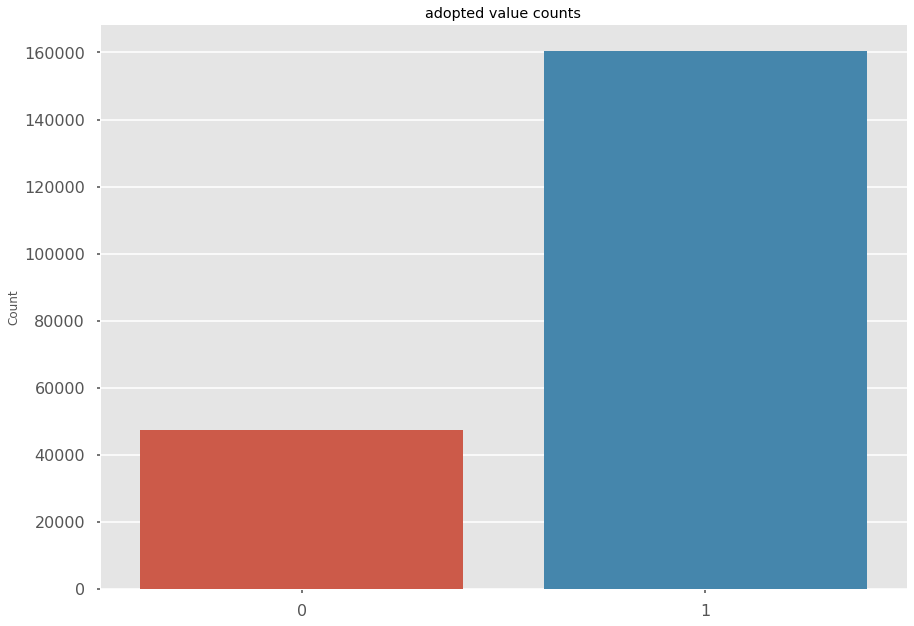

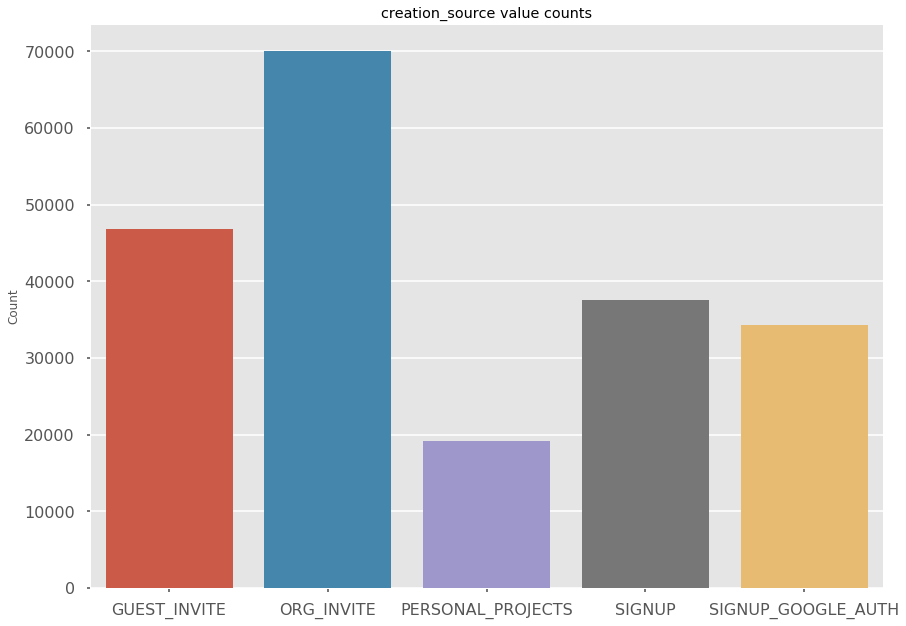

In [23]:
# bar plots to assess counts
df_columns = ['adopted', 'creation_source']
style.use('seaborn-poster')
style.use('ggplot')
for i, col in enumerate(df_columns):
    counts = df[col].value_counts()[:10]
    plt.figure(i)
    plt.title(col + ' value counts')
    plt.ylabel('Count')
    sns.barplot(counts.index, counts.values)
    plt.tight_layout()
   
    



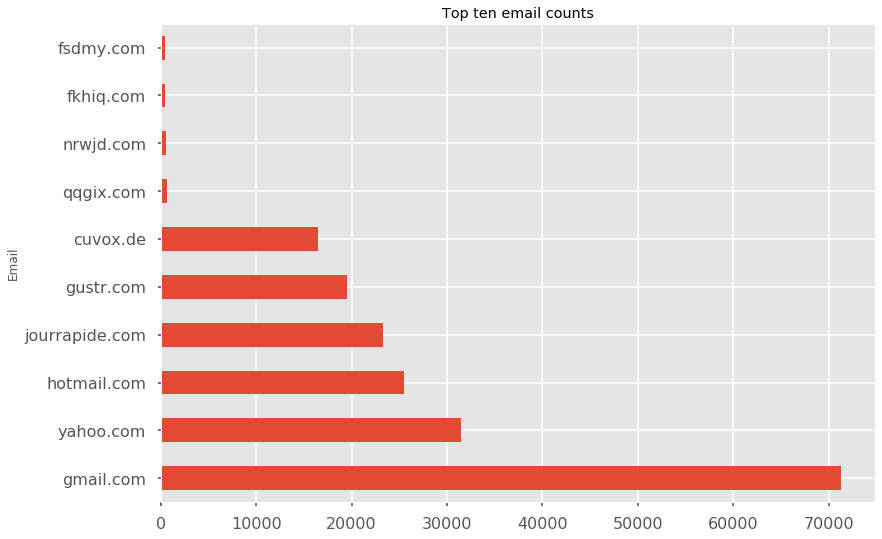

In [24]:
# horizontal bar graphs for email and organizational id
email_counts = df['email'].value_counts()[:10]
email_counts.plot(kind = 'barh', )
plt.title('Top ten email counts');
plt.ylabel('Email');


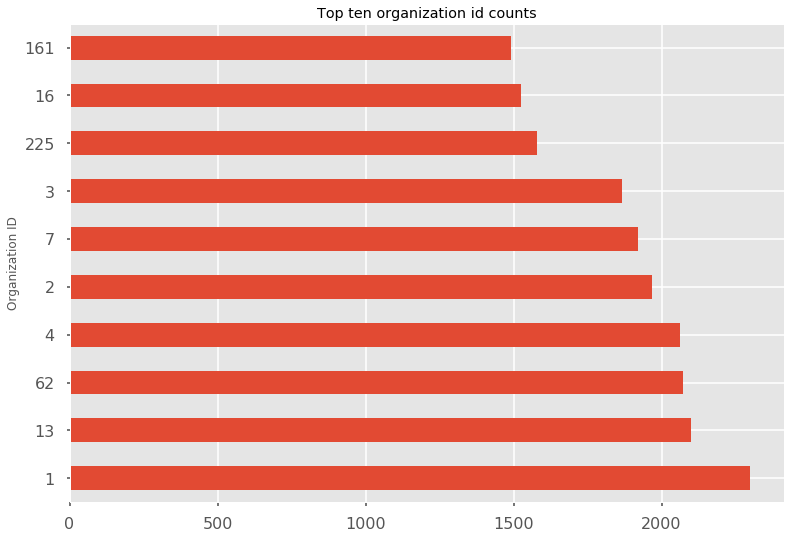

In [25]:
org_count = df['org_id'].value_counts()[:10]
org_count.plot(kind = 'barh', )
plt.title('Top ten organization id counts');
plt.ylabel('Organization ID');

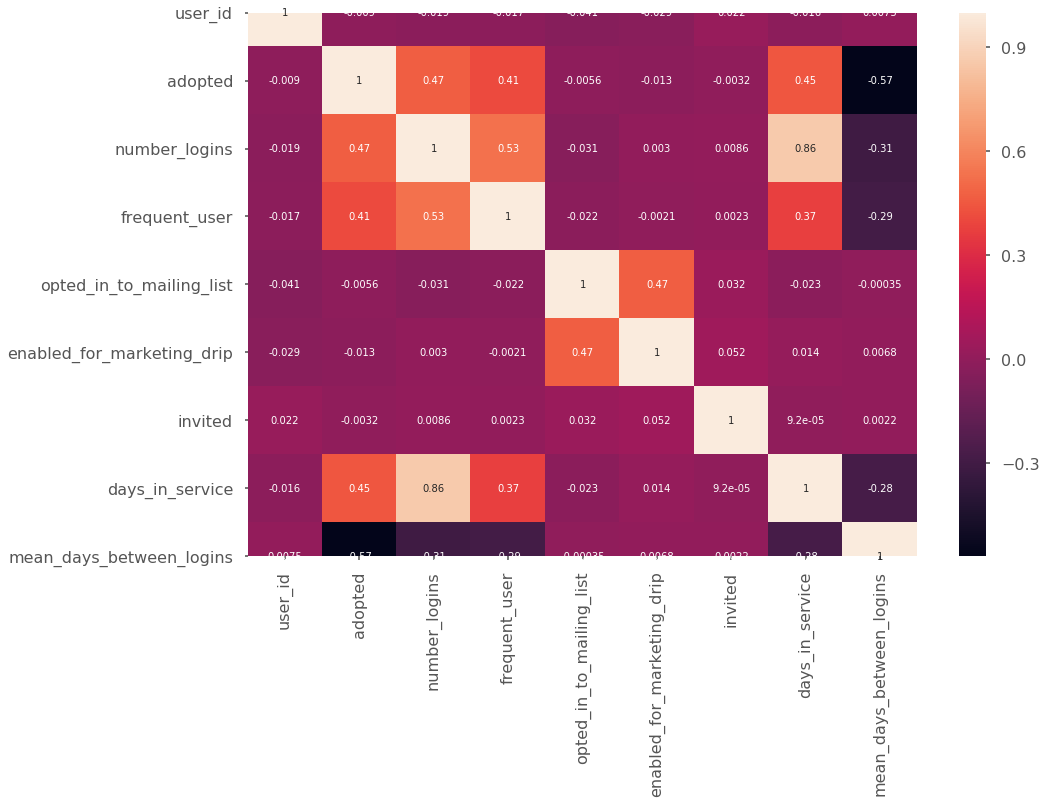

In [26]:
#look for any highly correlated features 
correlation_plot = df.corr()
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(correlation_plot, annot=True, ax= ax)
# 

# Feature Importance

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 16 columns):
time_stamp                    207917 non-null datetime64[ns]
user_id                       207917 non-null int64
adopted                       207917 non-null int64
number_logins                 207917 non-null int64
frequent_user                 207917 non-null int64
object_id                     207917 non-null category
creation_time                 207917 non-null datetime64[ns]
email                         207917 non-null category
creation_source               207917 non-null category
last_session_creation_time    207917 non-null datetime64[ns]
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null category
invited                       207917 non-null int64
days_in_service               207917 non-null float64
mean_days_between_logins      199094 non-null float64
dtypes: catego

In [28]:
# drop columns with datetime or category as type to use pca/ featurte union 
clean_df = df.drop(['time_stamp', 'object_id', 'creation_time', 'last_session_creation_time'],  axis = 1)

In [29]:
# mean amount of days between logins of each user
# impute mean_days_between_logins with mean of 2.58. not many outliers so mean is adequate
clean_df['mean_days_between_logins'] = df.groupby('user_id').time_stamp.apply(lambda x: x - x.shift()).dt.days

In [30]:
# These will be used as the base for X and y variables throughout the notebook
X, y = clean_df.drop('adopted', axis=1), clean_df.adopted
X.set_index('user_id', inplace = True)

In [31]:
# Instantiate classifier model      
lgbm = lgb.LGBMClassifier(class_weight=None,
                        colsample_bytree=1.0, importance_type='split',
                        learning_rate=0.1, max_depth=-1,
                        min_child_samples=20, min_child_weight=0.001,
                        min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                        num_leaves=31, objective='binary',
                        random_state=None, reg_alpha=0.0,                            
                        reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)   

In [32]:
# lgb accepts a certain format for the model
d_train = lgb.Dataset(X, 
                      label = y,
                      categorical_feature = ['email', 'creation_source', 'org_id']
                     )


In [33]:
params = {'objective': 'binary',
          'metric':'auc' 
         }

In [34]:
# first run training model
lgbm = lgb.train(params, train_set = d_train)

C:\Users\KETT\Anaconda3\envs\ML_gbms\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


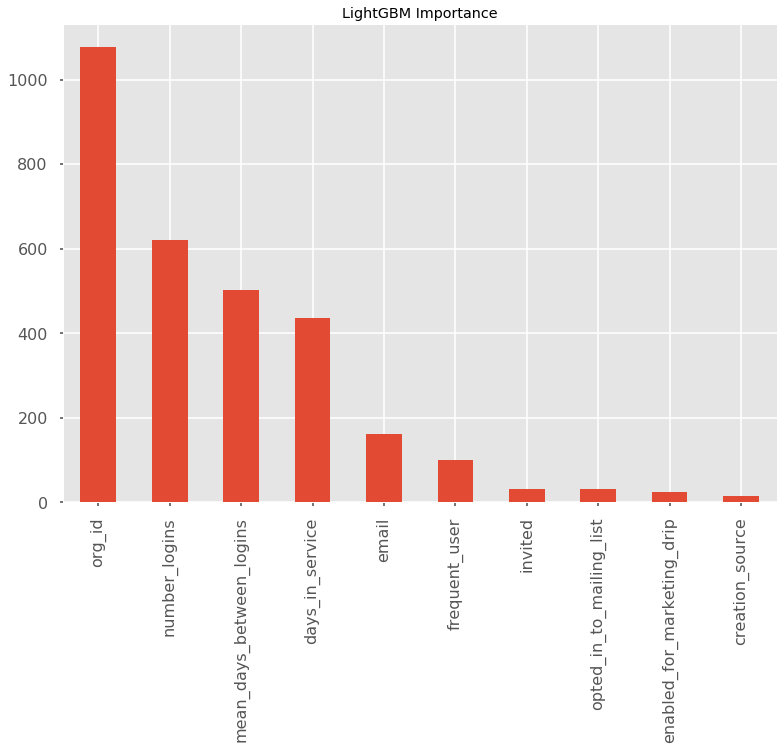

In [35]:
#lightgbm variable importance bar graph
#print list(var_names.values)
pd.Series(lgbm.feature_importance(), X.columns ).sort_values(ascending=False).plot(kind='bar', title='LightGBM Importance');

   # Brief writeup of findings:<br>
The most significant features while determining user adoption are ‘organizational_id’ and trailing far behind are ‘number_of_logins’ and ‘mean_days_between_logins.’ Orgnization_id was used as a categorical feature and surprisingly surpassed other features. Perhaps this suggests that the organizations have paradigms that utilize these services and logins are an everyday function of work. It would be a good idea to investigate these organizations and find out what industry they occupy and what are the objectives of that company. By identifying the role the software plays in the company, there may be some knowledge gained and improvements made to spread this knowledge to other customers. I had initially thought the number of times a user has logged in and the amount of days in service would be the top features. Logically one would think that the amount of times a person logged in would correlate to the amount of use this service gets and the same goes for the amount of time in service. People are creatures of habit and the longer a person uses this service, the more adapted and comfortable a user is and therefore will naturally adopt the service. I think further investigation should be done to identify the frequencies of email domain of the organizations that have the most adopted users and those with the least adopted users. There could be a software issue with the email services used. 